<a href="https://colab.research.google.com/github/ugadimas25/cv/blob/main/PlenoChallenge_Objective2_Download_Sentinel_And_Calculate_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install remotior_sensus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.2/260.2 kB 7.0 MB/s eta 0:00:00


In [2]:
import remotior_sensus
rs = remotior_sensus.Session(n_processes=2, available_ram=10240)

## a. Perform a Query

We can use the function [**download_products.search**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.tools.download_products.html#remotior_sensus.tools.download_products.search) to **query the Sentinel-2 database** and retrieve a table of available images.

In this case we are going to search images that match the **tile name** (using the argument `name_filter` level 2A images are retrieved). Alternatively, we could use the argument `coordinate_list=[left, top, right, bottom]` to search an area by WGS84 coordinates.

We set a period range (`date_from` and `date_to`), and a threshold for **maximum cloud cover** (`max_cloud_cover`).


>*There could be error messages if the results of Copernicus Data Space Ecosystem API are not found in the Google public service.*

In [11]:
query_result = rs.download_products.search(
    product='Sentinel-2', name_filter='48MXU',
    date_from='2022-01-01', date_to='2022-12-30',
    max_cloud_cover=10
)

 search [100%]: ⬤

## b. Query Results
The `query_result` is an object [**OutputManager**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.output_manager.html) including a product table (NumPy recarray) that we can retrive with the attribute `extra['product_table']`.




In [12]:
product_table = query_result.extra['product_table']
print(product_table)

[('Sentinel-2', 'L2A_T48MXU_A036780_20220708T031928', 'S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317', '2022-07-08', 8, '48MXU', 'None', -6.42071559, 105.90265807, -5.42525944, 106.89689078, 'None', 'None', 'https://storage.googleapis.com/gcp-public-data-sentinel-2/L2/tiles/48/M/XU/S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317.SAFE/GRANULE/L2A_T48MXU_A036780_20220708T031928/QI_DATA/T48MXU_20220708T025541_PVI.jp2', 'S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317')]


We can have a look at the **table fields**, which include information such as acquisition date, cloud cover, and a preview link. For instance, we can read the records of the first image in the table.

In [13]:
print(product_table[0].pprint())

         product: Sentinel-2
           image: L2A_T48MXU_A036780_20220708T031928
      product_id: S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317
acquisition_date: 2022-07-08
     cloud_cover: 8
       zone_path: 48MXU
             row: None
         min_lat: -6.4207155874509
         min_lon: 105.90265806636
         max_lat: -5.4252594369212
         max_lon: 106.89689078193
      collection: None
            size: 1
         preview: https://storage.googleapis.com/gcp-public-data-sentinel-2/L2/tiles/48/M/XU/S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317.SAFE/GRANULE/L2A_T48MXU_A036780_20220708T031928/QI_DATA/T48MXU_20220708T025541_PVI.jp2
             uid: S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317


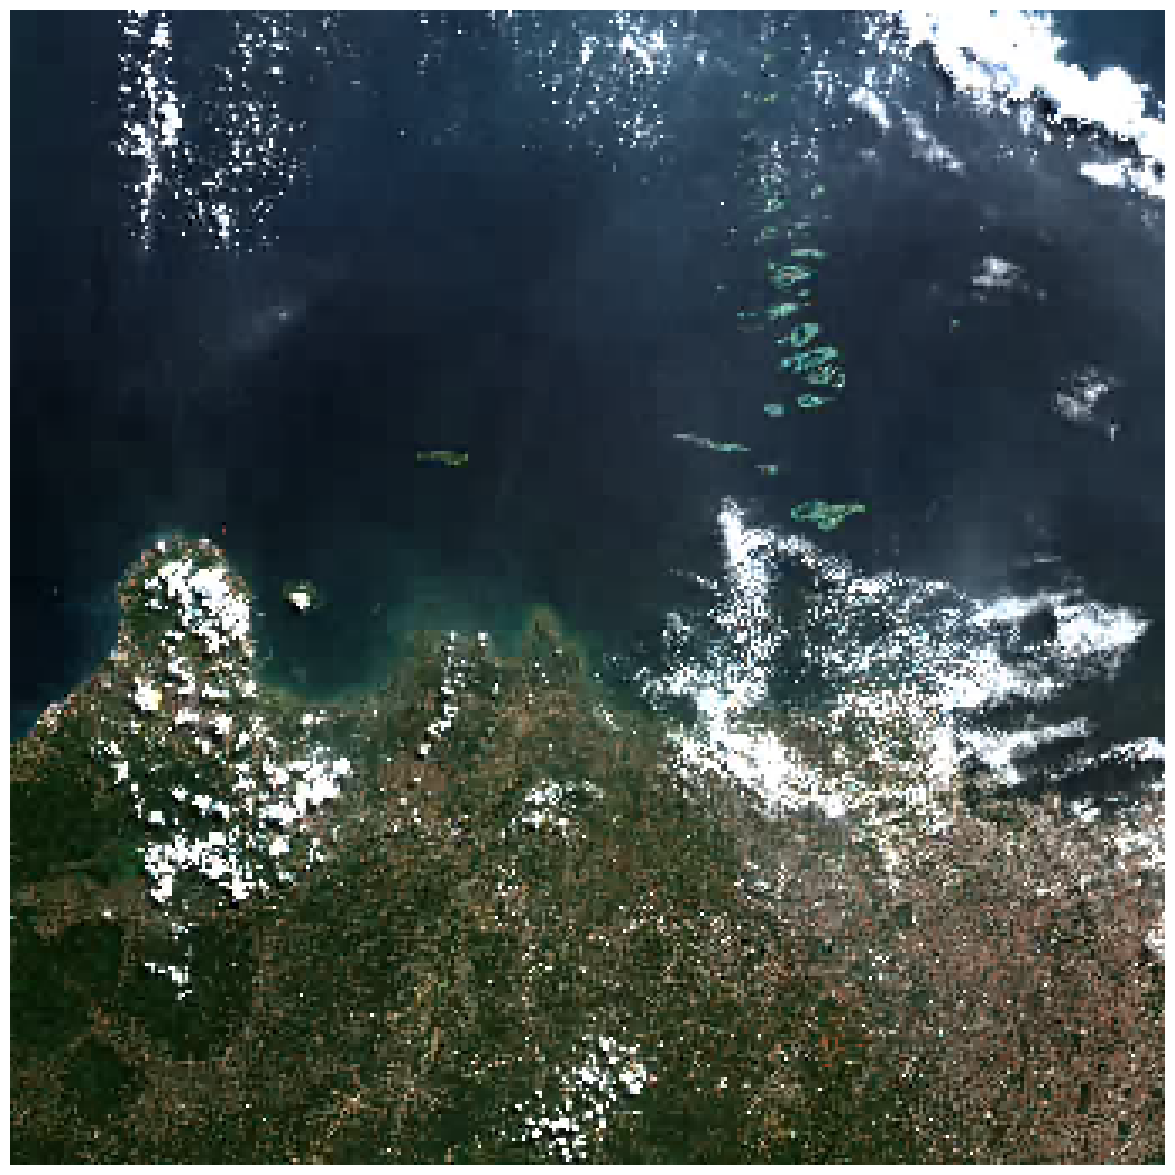

In [14]:
#@title Figure
import requests
from PIL import Image
import matplotlib.pyplot as plt
request = requests.get(product_table[0].preview)
file = open('/tmp/preview.jp2', 'wb')
file.write(request.content)
file.close()
preview = Image.open('/tmp/preview.jp2')
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.imshow(preview)

## c. Product Filtering

Now we can download all the images in the table, or select a subset of images by **filtering** the `product_table` on any of the available fields.

For instance, it is possible to select an image by name (field `image`), using the methods of NumPy recarrays.

In [15]:
image_table = product_table[
    product_table['image'] == 'L2A_T33TTG_A037013_20220724T100037'
    ]

print(image_table)

[]


It is possible to **filter by defining a condition**.
In particular, we exclude the images without a preview link (which are not available in Google public service).

In [16]:
filtered_table = product_table[
    product_table['preview'] != 'None'
    ]

print(filtered_table)

[('Sentinel-2', 'L2A_T48MXU_A036780_20220708T031928', 'S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317', '2022-07-08', 8, '48MXU', 'None', -6.42071559, 105.90265807, -5.42525944, 106.89689078, 'None', 'None', 'https://storage.googleapis.com/gcp-public-data-sentinel-2/L2/tiles/48/M/XU/S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317.SAFE/GRANULE/L2A_T48MXU_A036780_20220708T031928/QI_DATA/T48MXU_20220708T025541_PVI.jp2', 'S2A_MSIL2A_20220708T025541_N0400_R032_T48MXU_20220708T073317')]


## d. Image Download

We define a working directory where to save the data of this tutorial.

In [17]:
working_directory = '/home/tutorial'

To download the images, we pass the `filterd_table` as `product_table` argument to the function [**download_products.download**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.tools.download_products.html#remotior_sensus.tools.download_products.download).


Considering that we are going to **calculate NDVI**, we download only **bands 4 and 8** for **red and near-infrared** respectively.
Bands are selected with the argument `band_list` which is a list of band names which for Sentinel-2 are:
*'01', '02', '03', '04', '05', '06', '07', '08', '8a', '09', '10', '11', '12'*.

We define an `output_directory` where downloaded files are saved.

In [18]:
downloaded_images = rs.download_products.download(
    product_table=filtered_table,
    band_list=['04', '08'],
    output_path=working_directory + '/downloaded_images',
    )

 download products [100%] [elapsed 0min12sec]: ⬤

During the download, a directory inside the `output_directory` was created for each downloaded image.

`downloaded_images` is an an object [**OutputManager**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.output_manager.html) that includes a list of created directories in the attribute `extra['directory_paths']`.

We define image_directories


In [19]:
print(downloaded_images.extra['directory_paths'])

['/home/tutorial/downloaded_images/L2A_T48MXU_A036780_20220708T031928_2022-07-08']


In [20]:
preprocessed_image_directories = []
for directory in downloaded_images.extra['directory_paths']:
  preprocessed = rs.preprocess_products.preprocess(
      sensor='Sentinel-2',
      input_path=directory,
      output_path=directory + '/preprocessed',
      nodata_value=0
    )
  preprocessed_image_directories.append(directory + '/preprocessed')
  print('\n', directory + '/preprocessed')

 preprocess products [100%] [elapsed 0min40sec]: ⬤
 /home/tutorial/downloaded_images/L2A_T48MXU_A036780_20220708T031928_2022-07-08/preprocessed


## e. Single Calculation

For educational purpose, we are going to calculate NDVI for a single image.
First, we get the path of the last image that was preprocessed.

In [21]:
red_path = preprocessed.paths[0]
nir_path = preprocessed.paths[1]

print(red_path)
print(nir_path)

/home/tutorial/downloaded_images/L2A_T48MXU_A036780_20220708T031928_2022-07-08/preprocessed/T48MXU_A036780_20220708T031928_B04.tif
/home/tutorial/downloaded_images/L2A_T48MXU_A036780_20220708T031928_2022-07-08/preprocessed/T48MXU_A036780_20220708T031928_B08.tif


Using `band_calc`, it is possible to create an expression defining the `input_raster_list` as a list where each element is a list *\[raster path, variable name\]*.
Then, in `expression_string` we define the calculation expression according to the variable names defined in `input_raster_list`. The variable names must be between quotes.

In [22]:
calculation = rs.band_calc(
    input_raster_list=[[nir_path, 'nir'], [red_path, 'red']],
    expression_string='("nir" - "red") / ("nir" + "red")',
    output_path=working_directory + '/ndvi.tif'
)

 band calc [100%] [elapsed 0min39sec]: ⬤

The `calculation` is an object including the paths of calculation output with the argument `paths`.
In this case, the first element of the list is the calculated NDVI.

In [23]:
ndvi = calculation.paths[0]
print(ndvi)

/home/tutorial/ndvi.tif


We can have a look at the NDVI (using GDAL and Matplotlib).

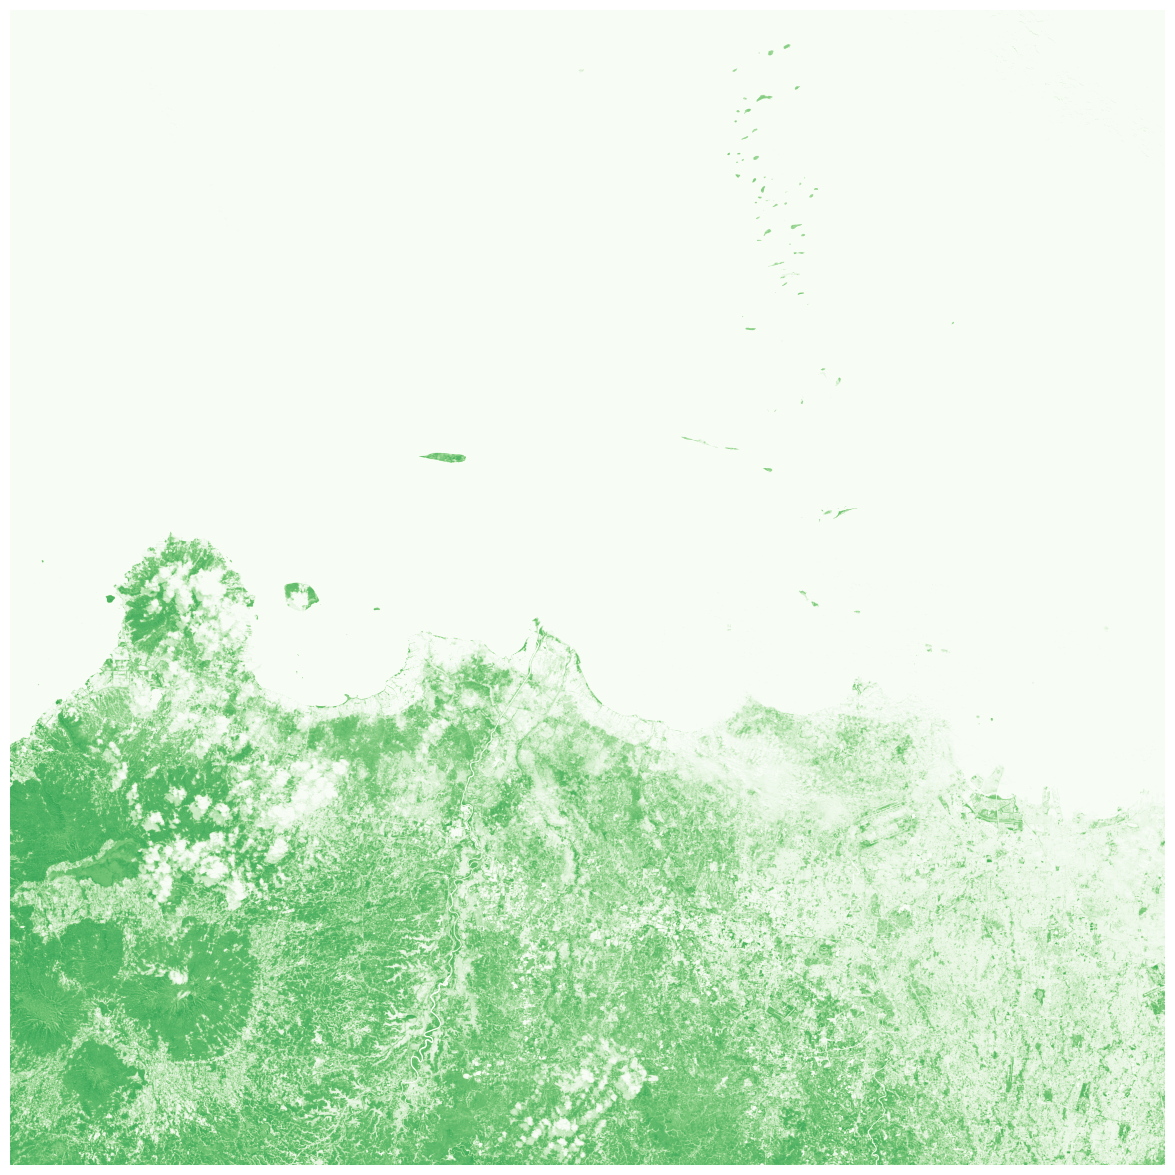

In [24]:
#@title Figure
from osgeo import gdal
import matplotlib.pyplot as plt

image = gdal.Open(ndvi)
band = image.GetRasterBand(1).ReadAsArray()
plt.imshow(band, cmap='Greens', vmin=0, vmax=1)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.show()
band = image = plt = None

## f. Create a BandSet Catalog


In [25]:
catalog = rs.bandset_catalog()

In [27]:
for directory in downloaded_images.extra['directory_paths']:
  print(directory)
  catalog.create_bandset(
      paths=[directory + '/preprocessed', 'tif'],
      wavelengths=['Sentinel-2'], date='auto',
      bandset_number=100, insert=True)

/home/tutorial/downloaded_images/L2A_T48MXU_A036780_20220708T031928_2022-07-08


In [28]:
print(catalog.bandsets_table)

[(1, 'BandSet',        'NaT', 'None', 'None', nan, nan, nan, nan, '20230822_103336831333_169')
 (2, 'T48MXU_A036780_20220708T031928_B', '2022-07-08', 'None', 'PROJCS["WGS 84 / UTM zone 48S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32748"]]', nan, nan, nan, nan, '20230822_103340935750_419')
 (3, 'T48MXU_A036780_20220708T031928_B', '2022-07-08', 'None', 'PROJCS["WGS 84 / UTM zone 48S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG"

We can see more in detail a BandSet.
The date was automatically extracted from the image directory name.

In [29]:
print(catalog.bandsets_table[1].pprint())

       bandset_number: 2
         bandset_name: T48MXU_A036780_20220708T031928_B
                 date: 2022-07-08
       root_directory: None
                  crs: PROJCS["WGS 84 / UTM zone 48S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32748"]]
  box_coordinate_left: nan
   box_coordinate_top: nan
 box_coordinate_right: nan
box_coordinate_bottom: nan
                  uid: 20230822_103340935750_419


Now, remove the BandSet 1 which is empty (it was the first BandSet created automatically by the Catalog).

In [30]:
# get the count of BandSets
print('BandSet count:', catalog.get_bandset_count())

# get the first BandSets and check that there are no bands
bandset_1 = catalog.get_bandset(1)
print('BandSet 1 bands:', bandset_1.bands)

# remove the BandSet 1
catalog.remove_bandset(1)

# get the count of BandSets
print('BandSet count:', catalog.get_bandset_count())

BandSet count: 3
BandSet 1 bands: []
BandSet count: 2


## Multiple Calculations with BandSets

We can perform the **NDVI calculation by iterating through the BandSets** previously defined in the Catalog.

In [31]:
ndvi_catalog = rs.bandset_catalog()
for bandset in catalog.get_bandsets_by_list():
  calculation = bandset.calc(expression_string='"#NDVI#"')
  ndvi_catalog.add_band_to_bandset(path=calculation.path, bandset_number=1)

 band calc [100%] [elapsed 0min17sec]: ⬤

## Calculate the Average NDVI

In [32]:
calculation = ndvi_catalog.get(1).calc(
    expression_string='mean("b*")',
    output_path=working_directory + '/average_ndvi.vrt'
)

 band calc [100%] [elapsed 0min29sec]: ⬤

We can see the resulting raster.

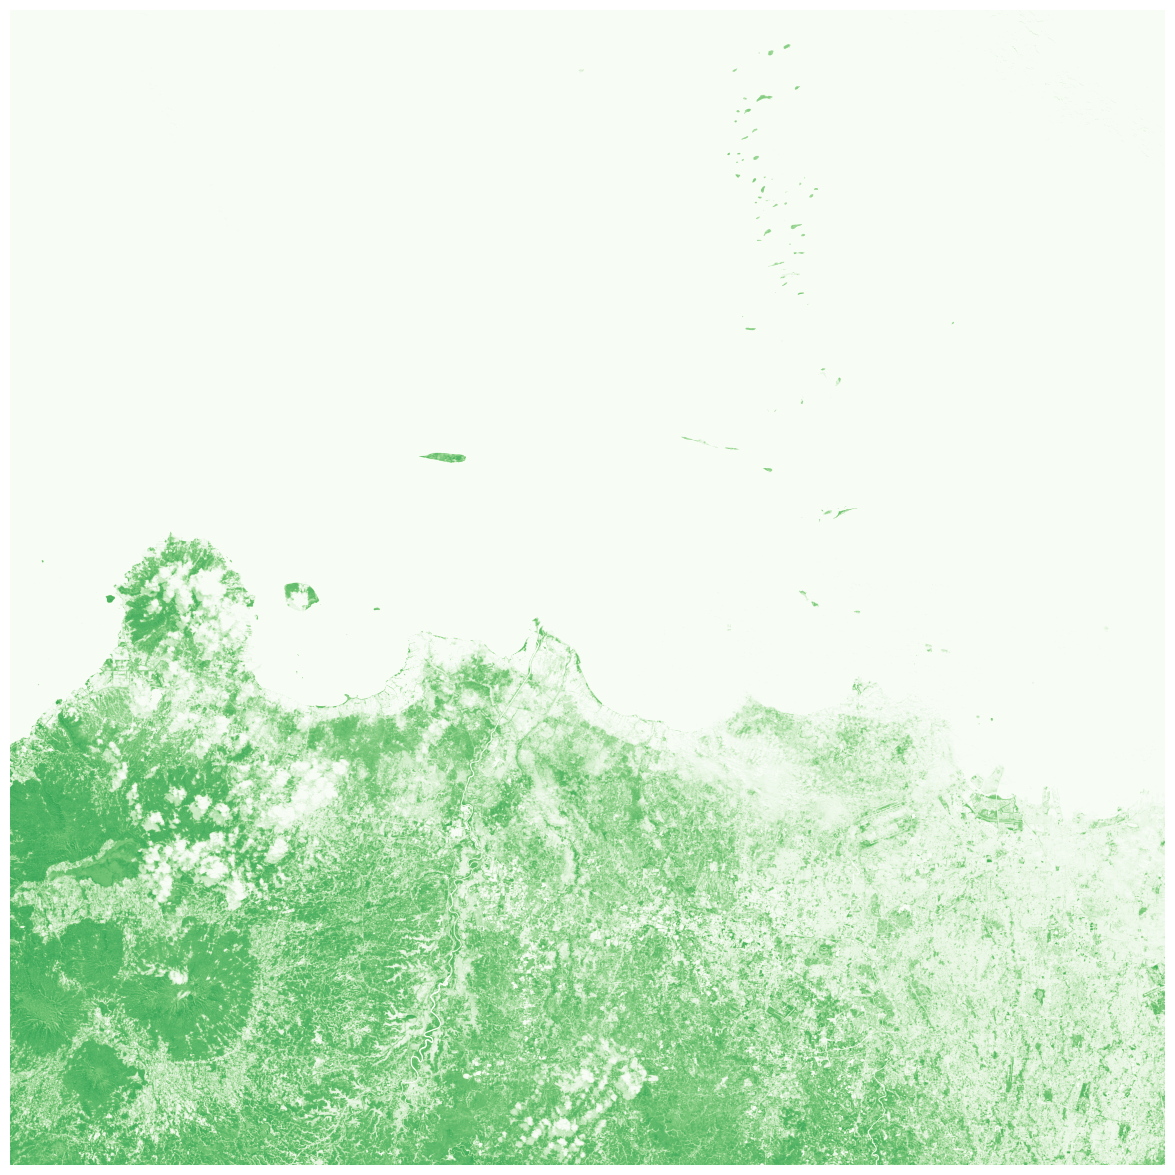

In [33]:
#@title Figure
from osgeo import gdal
import matplotlib.pyplot as plt

image = gdal.Open(calculation.path)
band = image.GetRasterBand(1).ReadAsArray()
plt.imshow(band, cmap='Greens', vmin=0, vmax=1)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.show()
band = image = plt = None

## Calculate the Maximum NDVI

In a similar fashion, we can calculate the maximum value of NDVI.

`calc()` performs the calculation according to the `expression_string` that we provide as positional argument `'max("b*")'`, to calculate the maximum value at pixel level using all the bands in the BandSet.

The second argument `working_directory + '/max_ndvi.vrt'` is the `output_path`.

In [34]:
calculation = ndvi_catalog.get(1).calc('max("b*")', working_directory + '/max_ndvi.vrt')

 band calc [100%] [elapsed 0min22sec]: ⬤

We can see the result.

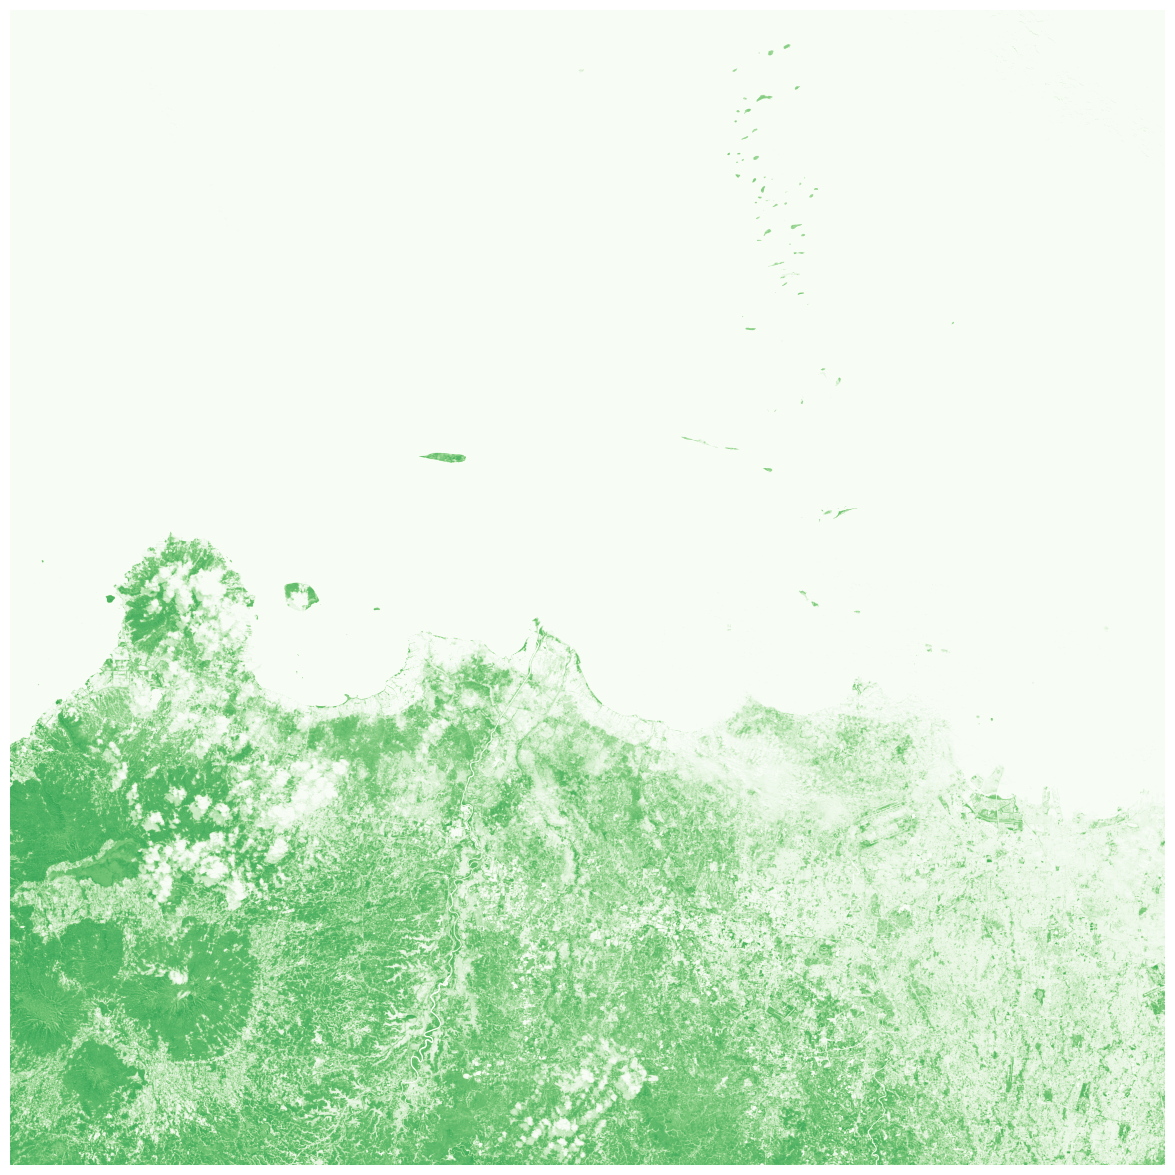

In [35]:
#@title Figure
from osgeo import gdal
import matplotlib.pyplot as plt

image = gdal.Open(calculation.path)
band = image.GetRasterBand(1).ReadAsArray()
plt.imshow(band, cmap='Greens', vmin=0, vmax=1)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.show()
band = image = plt = None

Of course these values are affected by cloud cover. Other tutorials will describe the process of cloud masking.

# Close the Session
The session should be closed at the end of all the processes to **remove the temporary files and stop subprocesses**.

In [ ]:
rs.close()